<a href="https://colab.research.google.com/github/cboyda/MachineLearning/blob/main/PA3_Team1_W23_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PA3: k-NN**

Team member names:

*  Brett Adams
*  Cailenys Leslie
*  Clinton Boyda (CAB)
*  Tanvir Hossain
*  Ram Dershan

Dataset: 
[New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from  sklearn import neighbors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Connect to Dataset

#filename = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"

#df = pd.read_csv(filename)

# we can work on merging the new dataset in the code below = Brett?

# load both data sets in
original = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"
df_original = pd.read_csv(original)
additional = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/full_nyc_dataset_cleaned_table-1.csv"
df_additional = pd.read_csv(additional)

In [3]:
# Merge the two datasets with an inner join, validate that no duplicate id values exist for a one to one join
df = pd.merge(df_original, df_additional, how = "inner", on = "id", validate="one_to_one", suffixes=("_original","_additional"))
df.shape

(16005, 22)

In [4]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type_original', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'room_type_additional',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds'],
      dtype='object')

# Data Cleaning

In [5]:
# check value counts for property_type
df['property_type'].value_counts()

Entire rental unit                    6975
Private room in rental unit           5153
Private room in home                   844
Entire home                            513
Entire condo                           418
Private room in townhouse              352
Entire loft                            326
Entire townhouse                       297
Private room in condo                  180
Shared room in rental unit             178
Private room in loft                   149
Entire guest suite                     133
Entire serviced apartment               98
Room in boutique hotel                  68
Room in hotel                           56
Private room in guest suite             37
Entire place                            33
Room in serviced apartment              24
Shared room in loft                     19
Entire guesthouse                       19
Private room                            18
Private room in resort                  17
Private room in bed and breakfast       14
Shared room

There are property types that we do not want to consider in our analysis (Boats, Caves and Villa's) so we will remove these examples.

In [6]:
# Check shape before dropping examples
df.shape

(16005, 22)

In [7]:
df = df.drop(df[(df['property_type'] == 'Cave') | (df['property_type'] == 'Boat') | 
                (df['property_type'] == 'Floor') | (df['property_type'] == 'Private room in farm stay') |
                (df['property_type'] == 'Entire villa') | (df['property_type'] == 'Private room in houseboat') |
                (df['property_type'] == 'Private room in villa') | (df['property_type'] == 'Private room in tent') |
                (df['property_type'] == 'Houseboat')].index)

In [8]:
# Check shape after dropping examples
df.shape

(15986, 22)

In [9]:
# assess new value counts for property_type
df['property_type'].value_counts()

Entire rental unit                    6975
Private room in rental unit           5153
Private room in home                   844
Entire home                            513
Entire condo                           418
Private room in townhouse              352
Entire loft                            326
Entire townhouse                       297
Private room in condo                  180
Shared room in rental unit             178
Private room in loft                   149
Entire guest suite                     133
Entire serviced apartment               98
Room in boutique hotel                  68
Room in hotel                           56
Private room in guest suite             37
Entire place                            33
Room in serviced apartment              24
Entire guesthouse                       19
Shared room in loft                     19
Private room                            18
Private room in resort                  17
Private room in bed and breakfast       14
Shared room

In [10]:
# extract the numerical values from the bathroom_text column for consideration 
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Shared half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Private half-bath', 0.5, inplace=True)
df['bathrooms'] = df['bathrooms_text'].str.extract(r'\b([\d.]+)\b')

In [11]:
# Convert bathroom to float type
df['bathrooms'] = df['bathrooms'].astype(float)

In [12]:
# drop bathroom_text, beds, and duplicated room_type column
df.drop(['bathrooms_text', 'room_type_additional', 'beds'], axis = 1, inplace = True)

In [13]:
# drop suffix from room_type_original
df = df.rename(columns = {'room_type_original' : 'room_type'})

In [14]:
# check for null values
df.isnull().sum()

id                                   0
name                                11
host_id                              0
host_name                           10
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3010
reviews_per_month                 3010
calculated_host_listings_count       0
availability_365                     0
property_type                        0
accommodates                         0
bedrooms                          1562
bathrooms                           52
dtype: int64

For bedrooms and bathrooms with null values, fill with zero as properties can have no bedrooms or bathrooms

In [15]:
df[['bedrooms', 'bathrooms']] = df[['bedrooms', 'bathrooms']].fillna(value=0)

In [16]:
# Check null values again to confirm
df.isnull().sum()

id                                   0
name                                11
host_id                              0
host_name                           10
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3010
reviews_per_month                 3010
calculated_host_listings_count       0
availability_365                     0
property_type                        0
accommodates                         0
bedrooms                             0
bathrooms                            0
dtype: int64

All other columns with null values are not important for this analysis as these columns will be dropped.

# **Feature Scaling**


In [17]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms'],
      dtype='object')

In [18]:
# drop all columns not necessary
# over simplifying for our first iteration

df.drop(['neighbourhood','name','host_name','number_of_reviews','last_review','reviews_per_month',
         'calculated_host_listings_count','id','host_id','latitude','longitude'], axis=1, inplace = True)
# df.drop('a', inplace=True, axis=1)

In [19]:
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])


In [20]:
#define clean as duplicate
df_clean = df.copy()

### 1. Check extreme values:

a. Define what an extreme value is for each feature, e.g., using boxplots.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

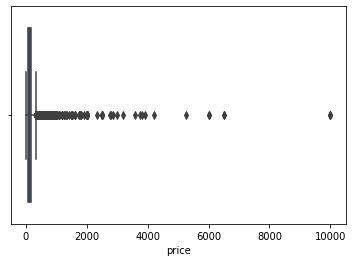

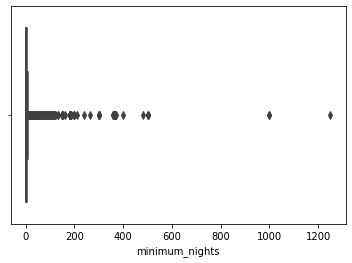

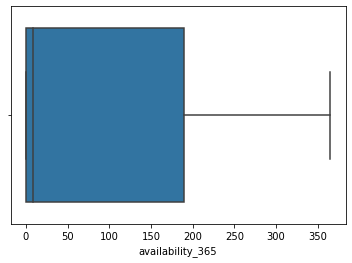

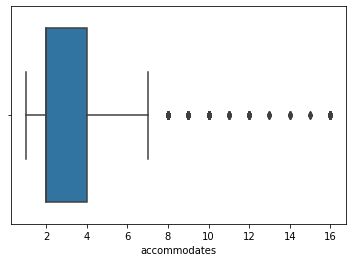

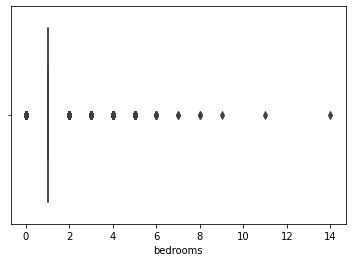

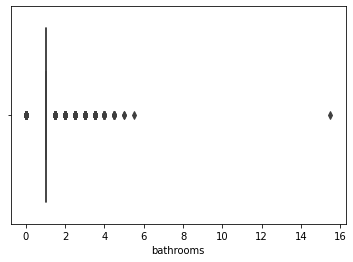

In [21]:
# create boxplots
for column in numeric_data.columns:
    plt.figure()            
    sns.boxplot(numeric_data[column])

In [22]:
# let's try looking at the histograms so the box plots are easier to read
for column in numeric_data.columns:
  fig = px.histogram(df_clean, x=column, marginal="box")
  fig.show()

In [23]:
extreme_values = []

In [24]:
for column in numeric_data.columns:
  # Select the first quantile
  q1 = df[column].quantile(0.25)

  # Select the third quantile
  q3 = df[column].quantile(0.75)

  max = df[column].quantile(1)

  # Create a mask inbetween q1 & q3
  IQR = q3 - q1

  # Filtering the initial dataframe with a mask
  #filtered = df.query('(@q1 - 1.5 * @IQR) <= [column] <= (@q3 + 1.5 * @IQR)')
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR  

  #maximum outliers
  bottom_fence = 0 if (q1 - 1.5 * IQR) < 0 else q1 - 1.5 * IQR
  upper_fence = max if (q3 + 1.5 * IQR) > max else (q3 + 1.5 * IQR)
  #display(column, bottom_fence, upper_fence)
  extreme_values.append([column, bottom_fence, upper_fence])


In [25]:
extreme_values

[['price', 0, 332.5],
 ['minimum_nights', 0, 11.0],
 ['availability_365', 0, 365.0],
 ['accommodates', 0, 7.0],
 ['bedrooms', 1.0, 1.0],
 ['bathrooms', 1.0, 1.0]]

In [26]:
df_clean.describe(include=['int64' , 'float64']).loc[['std','min','max','75%']]

,price,minimum_nights,availability_365,accommodates,bedrooms,bathrooms
std,239.672142,26.774995,127.801041,1.714661,0.744659,0.402003
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,10000.000000,1250.000000,365.000000,16.000000,14.000000,15.500000
75%,175.000000,5.000000,189.000000,4.000000,1.000000,1.000000


In [27]:
df_clean.describe()


,price,minimum_nights,availability_365,accommodates,bedrooms,bathrooms
count,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000
mean,150.066808,7.832041,96.467659,2.743213,1.169085,1.127768
std,239.672142,26.774995,127.801041,1.714661,0.744659,0.402003
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,70.000000,1.000000,0.000000,2.000000,1.000000,1.000000
50%,109.000000,3.000000,8.000000,2.000000,1.000000,1.000000
75%,175.000000,5.000000,189.000000,4.000000,1.000000,1.000000
max,10000.000000,1250.000000,365.000000,16.000000,14.000000,15.500000


In [28]:
# how many rows in our entire data?
df_clean.shape

(15986, 9)

In [29]:
df_clean.dtypes

neighbourhood_group     object
room_type               object
price                    int64
minimum_nights           int64
availability_365         int64
property_type           object
accommodates             int64
bedrooms               float64
bathrooms              float64
dtype: object

b. Do any of your features contain extreme values? List the features & the number of extreme values for each feature.


In [30]:
# confirm standard deviatin for price is too large = needs to drop extreme values
df_clean.describe(include='all').loc['std']

neighbourhood_group           NaN
room_type                     NaN
price                  239.672142
minimum_nights          26.774995
availability_365       127.801041
property_type                 NaN
accommodates             1.714661
bedrooms                 0.744659
bathrooms                0.402003
Name: std, dtype: object

In [31]:
# how many rows our price column?
df_clean.price.count()

15986

In [32]:
# lookup in extreme_values UPPER/LOWER FENCE values
def get_upperfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][2]
    else:
      continue

def get_lowerfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][1]
    else:
      continue


In [33]:
# looking at price specifically 75% is 175 but max is 10,000 so
# what is a good 'extreme' value? boxplot shows this as 374
df_clean.loc[df.price > get_upperfence('price'), 'price'].count()

873

In [34]:
# list of all rows that show price > extreme
df_clean.loc[df.price > get_upperfence('price')]

,neighbourhood_group,room_type,price,minimum_nights,availability_365,property_type,accommodates,bedrooms,bathrooms
22,Manhattan,Entire home/apt,375,180,180,Entire rental unit,4,2.0,2.0
38,Manhattan,Entire home/apt,500,4,243,Entire home,4,3.0,2.0
58,Brooklyn,Entire home/apt,475,3,230,Entire home,11,5.0,2.5
67,Queens,Entire home/apt,350,8,365,Entire townhouse,16,5.0,2.5
92,Manhattan,Entire home/apt,500,4,329,Entire loft,6,3.0,1.0
...,...,...,...,...,...,...,...,...,...
15950,Manhattan,Entire home/apt,400,2,66,Entire condo,4,1.0,1.0
15974,Manhattan,Entire home/apt,430,3,42,Entire rental unit,6,3.0,3.0
15979,Manhattan,Entire home/apt,350,3,8,Entire rental unit,2,1.0,1.0
15985,Manhattan,Entire home/apt,393,30,307,Entire rental unit,4,2.0,2.0


feature = availability_365 shows an extreme value for the value zero, and this really means that unit isn't available so best we just drop those indices to ensure we are only looking at available units!


In [35]:
df_clean['room_type'].value_counts()

Entire home/apt    8803
Private room       6963
Shared room         220
Name: room_type, dtype: int64

In [36]:
df_clean.loc[df.availability_365 == 0, 'availability_365'].count()

7362

In [37]:
df_clean[df_clean.availability_365 == 0]

,neighbourhood_group,room_type,price,minimum_nights,availability_365,property_type,accommodates,bedrooms,bathrooms
1,Brooklyn,Private room,60,45,0,Private room in rental unit,2,1.0,0.0
3,Manhattan,Private room,79,2,0,Private room in rental unit,1,1.0,1.0
7,Brooklyn,Entire home/apt,299,3,0,Entire loft,4,0.0,1.0
33,Brooklyn,Entire home/apt,100,5,0,Entire rental unit,2,1.0,1.0
44,Manhattan,Entire home/apt,100,4,0,Entire rental unit,3,0.0,1.0
...,...,...,...,...,...,...,...,...,...
15691,Queens,Private room,42,2,0,Private room in rental unit,2,1.0,1.0
15729,Manhattan,Entire home/apt,100,1,0,Entire rental unit,3,1.0,1.0
15865,Brooklyn,Private room,60,3,0,Private room in rental unit,1,1.0,1.0
15910,Queens,Private room,59,7,0,Private room in rental unit,2,1.0,1.0


In [38]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Availability_365 percentage over extreme:')
(df_clean.loc[df_clean.availability_365 == 0, 'availability_365'].count() / df_clean.availability_365.count()) * 100 

'Availability_365 percentage over extreme:'

46.052796196672084

Normally dropping 36% of the values would NOT be considered a good solution, but we assuming availability_365 is a range from 0 to 365.  If a unit is 0, this means the owner did not put it for rent for ANY days that year.  So why even offer that as a solution to a potential renter?  We interpret this to mean that 36% of inventory (rooms to rent) were simply not available during this period and that is not part of the business problem we are trying to solve nor analyze.

**BA - This percentage is now 46%**

In [39]:
# dropping availability_365 feature at this stage since it was a filter not a feature
# df_clean.drop(['availability_365'], axis=1, inplace = True)

In [40]:
df_clean.shape

(15986, 9)

c. Do the number of extreme values make-up a substantial portion of that feature? (e.g. 5%) Or are they so few that you could consider dropping those samples? Explain.


In [41]:
df_clean.loc[df_clean.price > get_upperfence('price'), 'price'].count()

873

In [42]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Pricing percentage over extreme:')
(df_clean.loc[df_clean.price > get_upperfence('price'), 'price'].count() / df_clean.price.count()) * 100 

'Pricing percentage over extreme:'

5.4610283998498685

Create new df_clean set with the extreme pricing values removed.

In [43]:
df_clean.drop(df_clean[df_clean['price'] > get_upperfence('price')].index, inplace = True)

In [44]:
df_clean.shape

(15113, 9)

In [45]:
# group the prices into categories
# view price
# log price
# break price into 3 groups based on ?? == 
# neighbour_groups becomes the colour background of the heat map
# (dots in the heatmap are the 5 neighbour_groups)

In [46]:
fig = px.histogram(df_clean, df_clean['price'], marginal="box")
fig.show()

Price needs log to get gaussian graph.

In [47]:
# log of zero fails so we count how many have zero, if small, then drop
df_clean.loc[df_clean.price  == 0, 'price'].count()

5

In [48]:
zero_price = df_clean.loc[df_clean.price  == 0, 'price'].index

In [49]:
# zero price rows is low, dropping
df_clean.drop(zero_price,axis=0,inplace=True)

In [50]:
# add log of price to dataframe
df_clean['log_price'] = np.log(df_clean['price'])

In [51]:
fig = px.histogram(df_clean, (df_clean['log_price']), marginal="box")
fig.show()

In [52]:
# break apart price groups by <q1, q1>median, median>q3, q3>
#price_q1 = df_clean['log_price'].quantile(0.25)
#price_mean = df_clean['log_price'].quantile(0.5)
#price_q3 = df_clean['log_price'].quantile(0.75)



In [53]:
# create new price_group text = "budget" or "average" or "high" or "luxury"
# df_clean["price_group"] = 'budget' if df_clean['log_price'] < price_q1 else 'average' if df_clean['log_price'] < price_median else 'high' if df_clean['log_price'] < price_q3 else 'luxury'


In [54]:
df_clean.columns

Index(['neighbourhood_group', 'room_type', 'price', 'minimum_nights',
       'availability_365', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms', 'log_price'],
      dtype='object')

### 2. Min-max scale your data and store this in a variable name that indicates that you’ve min-max scaled the data, e.g., X_train_minmax.

In [55]:
feature1 = df_clean["log_price"]
feature2 = df_clean["minimum_nights"]
feature3 = df_clean["availability_365"]
import sklearn.preprocessing
feature1_STD = feature1.std()
feature2_STD = feature2.std()
feature3_STD = feature3.std()
## create array of each features for processing
feature1_process = df_clean[["log_price"]].values
feature2_process= df_clean[["minimum_nights"]].values
feature3_process = df_clean[["availability_365"]].values
## create standardize and minmax object for each feature
feature1_mm = sklearn.preprocessing.MinMaxScaler()
feature1_mm_scaled = feature1_mm.fit_transform(feature1_process)
feature1_mm_scaled_STD = feature1_mm_scaled.std()
## create standardize and minmax object for each feature
feature2_mm = sklearn.preprocessing.MinMaxScaler()
feature2_mm_scaled = feature1_mm.fit_transform(feature2_process)
feature2_mm_scaled_STD = feature2_mm_scaled.std()
## create standardize and minmax object for each feature
feature3_mm = sklearn.preprocessing.MinMaxScaler()
feature3_mm_scaled = feature3_mm.fit_transform(feature3_process)
feature3_mm_scaled_STD = feature3_mm_scaled.std()

In [56]:
print('feature1 std = ', feature1_STD, 'feature1 mm std = ', feature1_mm_scaled_STD)
print('feature2 std = ', feature2_STD, 'feature2 mm std = ', feature2_mm_scaled_STD)
print('feature3 std = ', feature3_STD, 'feature3 mm std = ', feature3_mm_scaled_STD)

feature1 std =  0.5629836137015224 feature1 mm std =  0.16073003993259743
feature2 std =  26.72779686912616 feature2 mm std =  0.02139864875639864
feature3 std =  126.47498626700632 feature3 mm std =  0.3464953438407556


### 3. Standardize your data and store this in a variable name that indicates that you’ve standardized the data, e.g., X_train_standard.


In [57]:
# Standard Scalering
#feature 1
feature1_scaler = sklearn.preprocessing.StandardScaler()
feature1_scaled = feature1_scaler.fit_transform(feature1_process)
feature1_scaled_STD = feature1_scaled.std()

#feature 2
feature2_scaler = sklearn.preprocessing.StandardScaler()
feature2_scaled = feature1_scaler.fit_transform(feature2_process)
feature2_scaled_STD = feature2_scaled.std()

#feature 3
feature3_scaler = sklearn.preprocessing.StandardScaler()
feature3_scaled = feature3_scaler.fit_transform(feature3_process)
feature3_scaled_STD = feature3_scaled.std()



In [58]:
print('feature1 std = ', feature1_STD, 'feature1 standardize std = ', feature1_scaled_STD, 'feature1 mm std = ', feature1_mm_scaled_STD)
print('feature2 std = ', feature2_STD, 'feature2 standardize std = ', feature2_scaled_STD, 'feature2 mm std = ', feature2_mm_scaled_STD)
print('feature3 std = ', feature3_STD, 'feature1 standardize std = ', feature3_scaled_STD,'feature3 mm std = ', feature3_mm_scaled_STD)

feature1 std =  0.5629836137015224 feature1 standardize std =  1.0 feature1 mm std =  0.16073003993259743
feature2 std =  26.72779686912616 feature2 standardize std =  1.0 feature2 mm std =  0.02139864875639864
feature3 std =  126.47498626700632 feature1 standardize std =  0.9999999999999999 feature3 mm std =  0.3464953438407556


### 4. Visual & numeric comparison 1: Choose 3 features, and compare their standard deviations of after standardizing & min-max scaling. What is the difference between these two approaches on how your features are distributed [Hint: look at the mean].


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



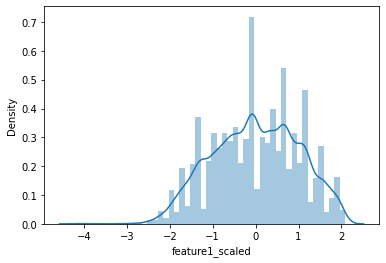

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



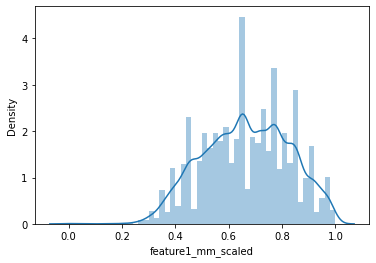

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



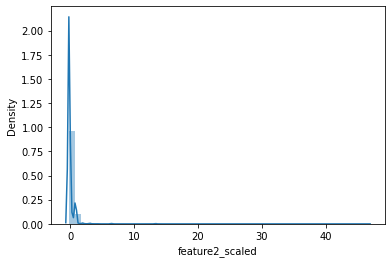

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



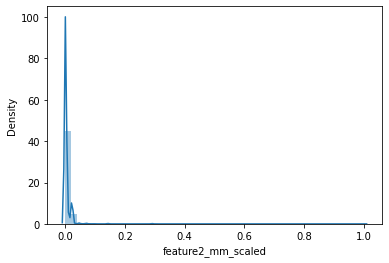

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



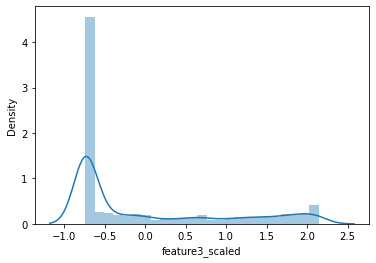

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



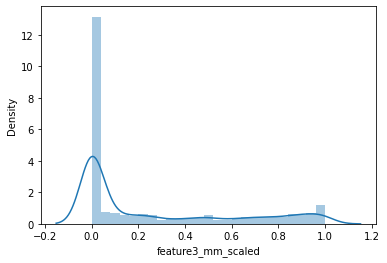

In [59]:
feature3_scaled.shape
all_features = [feature1_scaled,feature1_mm_scaled,feature2_scaled,feature2_mm_scaled,feature3_scaled,feature3_mm_scaled]

all_features_df = pd.DataFrame({'feature1_scaled':feature1_scaled[:,0], 'feature1_mm_scaled':feature1_mm_scaled[:,0],'feature2_scaled':feature2_scaled[:,0], 'feature2_mm_scaled':feature2_mm_scaled[:,0],'feature3_scaled':feature3_scaled[:,0], 'feature3_mm_scaled':feature3_mm_scaled[:,0]})


for i, column in enumerate(all_features_df.columns, 1):
    sns.distplot(all_features_df[column])
    plt.show()

### 5. Visual & numeric comparison 2: Generate a boxplot for all three datasets, the original, the  min-max scaled, and the standardized dataset. We expect to see a comparison like the one in lab, where each box-n-whiskers plot corresponds to a different feature.


In [60]:
df_clean.count()

neighbourhood_group    15108
room_type              15108
price                  15108
minimum_nights         15108
availability_365       15108
property_type          15108
accommodates           15108
bedrooms               15108
bathrooms              15108
log_price              15108
dtype: int64

In [61]:
# test for clean enough data to run k-NN
# zeros denote no nulls
df_clean.isna().sum()

neighbourhood_group    0
room_type              0
price                  0
minimum_nights         0
availability_365       0
property_type          0
accommodates           0
bedrooms               0
bathrooms              0
log_price              0
dtype: int64

In [62]:
df_clean['neighbourhood_group'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [63]:
df_clean.drop(['price'], axis=1, inplace = True)
df_clean

,neighbourhood_group,room_type,minimum_nights,availability_365,property_type,accommodates,bedrooms,bathrooms,log_price
0,Manhattan,Entire home/apt,1,355,Entire rental unit,1,0.0,1.0,5.416100
1,Brooklyn,Private room,45,0,Private room in rental unit,2,1.0,0.0,4.094345
2,Manhattan,Private room,2,220,Private room in rental unit,2,1.0,1.0,4.369448
3,Manhattan,Private room,2,0,Private room in rental unit,1,1.0,1.0,4.369448
4,Brooklyn,Private room,4,314,Private room in townhouse,2,1.0,1.5,4.488636
...,...,...,...,...,...,...,...,...,...
16000,Queens,Entire home/apt,3,300,Entire home,2,1.0,1.0,4.442651
16001,Manhattan,Private room,1,2,Private room in rental unit,2,1.0,1.0,4.553877
16002,Brooklyn,Entire home/apt,1,363,Entire rental unit,6,2.0,1.0,5.135798
16003,Brooklyn,Private room,6,15,Private room in rental unit,2,1.0,1.0,3.988984


In [64]:
column_names= df_clean.columns
features = column_names[1:]
label = column_names[0]
display(features, label)

Index(['room_type', 'minimum_nights', 'availability_365', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

'neighbourhood_group'

In [65]:
features

Index(['room_type', 'minimum_nights', 'availability_365', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

# **Exploring k-NN construction:**

In [66]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [67]:
X_preprocess = make_column_transformer((OrdinalEncoder(), features), remainder='passthrough')
y_preprocess = LabelEncoder()

In [68]:

y = y_preprocess.fit_transform(df_clean[label])
y

array([2, 1, 2, ..., 1, 1, 2])

In [69]:
df_clean.head()
X = X_preprocess.fit_transform(df_clean[features])
# X_new1 = X_preprocess.fit_transform(df_clean[['minimum_nights','log_price']])
X

array([[  0.,   0., 355., ...,   0.,   1., 210.],
       [  1.,  37.,   0., ...,   1.,   0.,  45.],
       [  1.,   1., 220., ...,   1.,   1.,  64.],
       ...,
       [  0.,   0., 363., ...,   2.,   1., 155.],
       [  1.,   5.,  15., ...,   1.,   1.,  39.],
       [  1.,   6.,  23., ...,   1.,   3.,  75.]])

In [70]:
X_new = X[:,[1,7]]


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1. Vary the n_neighbors parameter:

a. Create a k-NN classifier model querying 5 neighbors.

In [73]:
knn_1a = KNeighborsClassifier(n_neighbors=5)
knn_1a.fit(X_train, y_train)

KNeighborsClassifier()

b. Create a k-NN classifier model querying 11 neighbors.

In [74]:
knn_1b = KNeighborsClassifier(n_neighbors=11)
knn_1b.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

c. Create a k-NN classifier model querying 15 neighbors.

In [75]:
knn_1c = KNeighborsClassifier(n_neighbors=15)
knn_1c.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

###2. Vary the weights parameter:

a. Create a k-NN classifier model with weights parameter set to “uniform”.

In [76]:
knn_2a = KNeighborsClassifier(weights = "uniform")
knn_2a.fit(X_train, y_train)

KNeighborsClassifier()

b. Create a k-NN classifier model with weights parameter set to “distance”.

In [77]:
knn_2b = KNeighborsClassifier(weights = "distance")
knn_2b.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

# **k-NN evaluation:**

### 3. Plot the decision boundaries for each class for the different n_neighbors and weights.


In [78]:
# from https://stackoverflow.com/questions/72246343/importerror-cannot-import-name-decisionboundarydisplay-from-sklearn-inspecti
# pip install -U scikit-learn --user

In [79]:
features

Index(['room_type', 'minimum_nights', 'availability_365', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

In [80]:
#heatmap_features= (['room_type','log_price'])

In [81]:
len(y)

15108

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



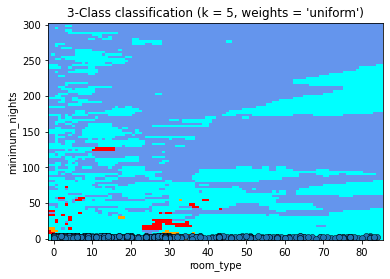

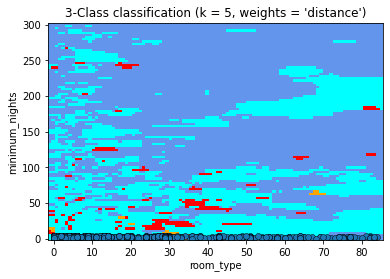

In [82]:
# from https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.colors import ListedColormap
# from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 5

# import some data to play with
# iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
# X and y already defined
# X = iris.data[:, :2]
# y = iris.target


# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue", "red"])
cmap_bold = ["darkorange", "c", "darkblue", "gray"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_new, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X_new,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=features[0],
        ylabel=features[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        X_new[:,0],
        y,
        # hue=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()

### 4. Use the sklearn.metrics.accuracy_score method to compare the accuracy of the several values of k, k=5, 11, and 15, and compare your original and your normalized (min-max scaled and standardized) datasets.


In [93]:
from sklearn.metrics import accuracy_score

In [ ]:
yhat_pid_test = knn_pid.predict(X_pid_test)
accuracy_score(y_pid_test, yhat_pid_test)

In [94]:
yhat_test = knn_1a.predict(X_test)
accuracy_score(y_test, yhat_test)

0.5337524818001324

In [97]:
print("knn_1a Accuracy:",accuracy_score(y_test, yhat_test))

knn_1a Accuracy: 0.5337524818001324


### 5. Test the performance of each k-NN classifier using other evaluation metrics (precision, recall and F1 scores) and see if there is any difference if you chose different metrics.


In [98]:
from sklearn.metrics import classification_report

In [120]:
y_preprocess.inverse_transform([0,1,2,3,4])

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

In [127]:
yhat_test = knn_1a.predict(X_test)

In [128]:
print("knn_1a On test data:")
print(classification_report(y_test, yhat_test, \
                           target_names=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']))

knn_1a On test data:
               precision    recall  f1-score   support

        Bronx       0.09      0.04      0.05        77
     Brooklyn       0.51      0.62      0.56      1303
    Manhattan       0.60      0.60      0.60      1245
       Queens       0.35      0.16      0.22       376
Staten Island       0.00      0.00      0.00        21

     accuracy                           0.53      3022
    macro avg       0.31      0.28      0.29      3022
 weighted avg       0.51      0.53      0.52      3022



In [129]:
yhat_test = knn_1b.predict(X_test)

In [152]:
import warnings
warnings.filterwarnings("ignore")

In [153]:
print("knn_1b On test data:")
print(classification_report(y_test, yhat_test, \
                           target_names=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']))

knn_1b On test data:
               precision    recall  f1-score   support

        Bronx       0.20      0.04      0.07        77
     Brooklyn       0.52      0.64      0.57      1303
    Manhattan       0.61      0.61      0.61      1245
       Queens       0.40      0.17      0.24       376
Staten Island       0.00      0.00      0.00        21

     accuracy                           0.55      3022
    macro avg       0.34      0.29      0.30      3022
 weighted avg       0.53      0.55      0.53      3022



### 6. Imagine that you have another classifier that always predicts the most common label, do a baseline comparison for your ML models.


In [143]:
# Lab3-3 has this value and the 614 is the shape of y_test but 398 is unknown
display(398 / 614)

0.6482084690553745

In [136]:
y_test.shape[0]

3022

In [145]:
display(398/ y_test.shape[0])

0.1317008603573792

In [134]:
y_train.shape[0]

12086

In [144]:
display(398/ y_train.shape[0])

0.0329306635776932

### 7. Generate a simple plot of the test and training learning curve for each k-NN and check if you have a low/high bias or low/high variance learning. We can use the function learning_curve to generate the values that are required to plot such a learning curve (number of samples that have been used, the average scores on the training sets and the average scores on the validation sets):


In [146]:
from sklearn.model_selection import learning_curve

In [147]:
data_sizes, training_scores, validation_scores = \
  learning_curve(KNeighborsClassifier(), X_train, \
                 y_train, cv=10, scoring='accuracy', \
                 train_sizes=np.linspace(0.01, 1.0, 51))

In [ ]:
display(data_sizes)

In [ ]:
display(training_scores)
display(training_scores.shape)

In [ ]:
display(validation_scores)
display(validation_scores.shape)

In [148]:
training_mean = training_scores.mean(axis=1) 
training_standard_deviation = training_scores.std(axis=1) 

In [149]:
validation_mean = validation_scores.mean(axis=1) 
validation_standard_deviation = validation_scores.std(axis=1)

In [150]:
import plotly.graph_objects as go

In [151]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean,
                        mode='lines',
                        name='Training',
                        line=dict(color='red')))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean - training_standard_deviation,
                        mode='lines',
                        name='Training lower bound',
                        line=dict(width=0, color='red'),
                        showlegend=False))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean + training_standard_deviation,
                        mode='lines',
                        name='Training upper bound',
                        line=dict(width=0, color='red'),
                        fill='tonexty',
                        fillcolor='rgba(255, 0, 0, 0.3)',
                        showlegend=False))

fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean,
                        mode='lines',
                        name='Validation',
                        line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean - validation_standard_deviation,
                        mode='lines',
                        name='Validation lower bound',
                        line=dict(width=0, color='blue'),
                        showlegend=False))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean + validation_standard_deviation,
                        mode='lines',
                        name='Validation upper bound',
                        line=dict(width=0, color='blue'),
                        fill='tonexty',
                        fillcolor='rgba(0, 0, 255, 0.3)',
                        showlegend=False))

fig.update_layout(title='Learning curve',
                 xaxis_title='Dataset size',
                 yaxis_title='Accuracy')
fig.show()